In [1]:
%matplotlib inline
from astropy.coordinates import SkyCoord
from astropy.io import ascii
from astroquery.irsa_dust import IrsaDust
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.integrate import quad
from scipy.optimize import curve_fit
import sncosmo
import sys
import tables

if sys.version_info.major != 2 and sys.version_info.minor != 7:
    raise RuntimeError("This notebook only works for python 2.7")

# Light curve fitting for a Type Ia supernova

Here we use the ```sncosmo``` module to fit the SALT2 template
to the iPTF16abc P48 and P60 light curves simultaneously

In [2]:
# run sncosmo
# filter data
fp = tables.open_file("filters.h5", mode="r")
filters = dict()
for filter_name in ["g", "R"]:
    filters["P48_" + filter_name] =\
        np.array([(row["wavelength"], row["transmission"])
                  for row in fp.root.P48.CFH12K._f_get_child(filter_name)],
                 dtype=[("wavelength", "f"), ("transmission", "f")])
for filter_name in ["g", "r", "i"]:
    filters["P60_" + filter_name] =\
        np.array([(row["wavelength"], row["transmission"])
                  for row in fp.root.P60.SEDm._f_get_child(filter_name)],
                 dtype=[("wavelength", "f"), ("transmission", "f")])
for key in filters:
    band = sncosmo.Bandpass(filters[key]["wavelength"],
                            filters[key]["transmission"],
                            name=key)
    sncosmo.registry.register(band)
fp.close()

In [90]:
# iPTF16abc data
h5file = tables.open_file("iPTF16abc.h5", mode="r")
table = h5file.root.photometry
# P48
lc = dict()
# for filter_name in ["g", "R"]:
#     key = "P48_%s" % filter_name
#     data = np.array([(row["time"], row["flux"], row["flux_err"])
#                      for row in table.where(
#                          "(telescope == b'P48') & (filter_name == b'%s')" % filter_name)
#                     ],
#                     dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f")])
#     np.sort(data, order=["time"])
#     lc[key] = data
# P60 light curve
for filter_name in ["g", "r", "i"]:
    key = "P60_%s" % filter_name
    data = np.array([(row["time"], row["flux"], row["flux_err"])
                     for row in table.where(
                         u"(telescope == b'P60') & (filter_name == b'%s')" % filter_name)
                    ],
                    dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f")])
    np.sort(data, order=["time"])
    lc[key] = data

    
params = {"ra": 203.689542, "dec": +13.853974, "z": 0.0234}

# Galactic extinction
pos = SkyCoord(params["ra"], params["dec"], frame="fk5", unit="deg")
table = IrsaDust.get_query_table(pos, section="ebv")
params["mwebv"] = float(table["ext SandF mean"])

# preparing fit datafile
with open("parameters.txt", "w") as fp:
    fp.write("@z %.3f\n" % params["z"])
    fp.write("@mwebv %.3f\n" % params["mwebv"])
    fp.write("@t %.3f\n" % 57500.)
    fp.write("time band flux fluxerr zp zpsys\n")
    zp = 2.5 * np.log10(3631)
#     for key in ["P48_R", "P48_g", "P60_g", "P60_r", "P60_i"]:
    for key in ["P60_g", "P60_r", "P60_i"]:
        for row in lc[key]:
            if row["time"] < 57484.6 or row["time"] > 57550:
                continue
            fp.write("%9.3f  %s  %.4e  %.4e  %.3f  %s\n" %\
                     (row["time"], key, row["flux"], row["flux_err"],
                      zp, "ab"))
d = sncosmo.read_lc("parameters.txt", format="ascii")

B-band peak mag: 15.58
The fit produces the following values:
        x_1 = 0.965465 +/- 0.000328
        c   = 0.012398 +/- 0.029266
        t_0  = 57499.537694 +/- 0.233610

    


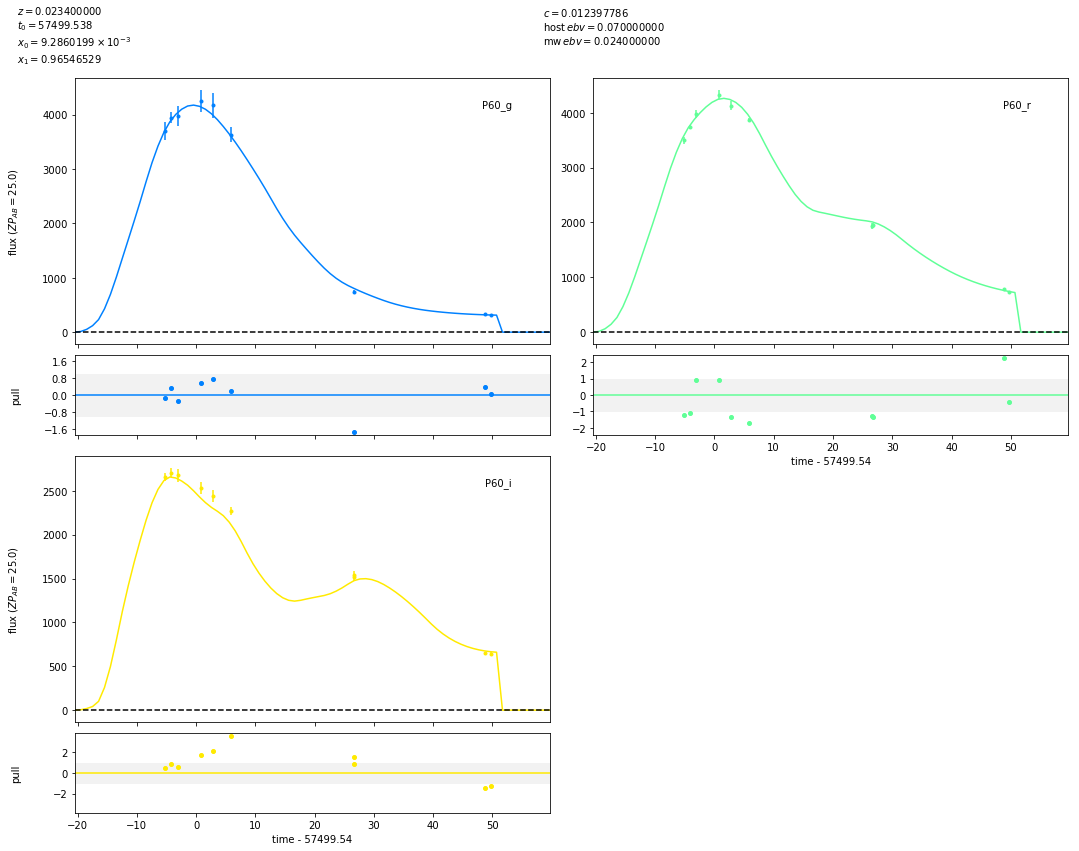

In [91]:
# sncosmo model
dust = sncosmo.F99Dust()
host_dust = sncosmo.F99Dust()
model = sncosmo.Model(source="salt2",
                      effects=[host_dust, dust],
                      effect_names=["host", "mw"],
                      effect_frames=["rest", "obs"])
model.set(z=params["z"])

model.set(t0=57598.)
model.set(hostebv=0.07)
model.set(mwebv=d.meta["mwebv"])

fit_parameter_list = ["t0", "x0", "x1", "c"]

res, fitted_model = sncosmo.fit_lc(d, model, fit_parameter_list,
                                   bounds={"t0": (57490, 57510), 
                                           "x1": (-5, 5)},
                                   guess_t0=False,
                                   modelcov = True)

fig = sncosmo.plot_lc(d, model=fitted_model, error=res.errors, xfigsize = 15)

m_Bast = fitted_model.source_peakmag(sncosmo.get_bandpass("bessellb"), 'ab')

print("B-band peak mag: {:5.2f}").format(m_Bast)

X_1 = res['parameters'][3]
X_1_err = res['errors']['x0']
C = res['parameters'][4]
C_err = res['errors']['c']
t_0 = res['parameters'][1]
t_0_err = res['errors']['t0']

print("""The fit produces the following values:
        x_1 = {:.6f} +/- {:.6f}
        c   = {:.6f} +/- {:.6f}
        t_0  = {:.6f} +/- {:.6f}

    """.format(X_1, X_1_err, C, C_err, t_0, t_0_err))

According to Betoule et al. 2014, the distance modulus, $\mu$ can be calculated as:

$$\mu = m_B^* - (M_B - \alpha \times X_1 + \beta \times C)$$

Under the assumption of no covariance between these parameters, the variance for $\mu$ can then be described as: 

$$\sigma_\mu^2 = \sigma_{m_B^*}^2 + \sigma_{M_B}^2 + X_1^2 \times \sigma_{\alpha}^2 + \alpha^2 \times \sigma_{X_1}^2 + \beta^2 \times \sigma_{C}^2 + C^2 \times \sigma_{\beta}^2 $$

In [93]:
# cosmology nuisance parameters
alpha = 0.141
alpha_err = 0.006
beta = 3.101
beta_err = 0.075
M_B1 = -19.05
M_B1_err = 0.02

mu = m_Bast - (M_B1 - alpha*X_1 + beta*C)
print("The distance modulus is {:.4f}".format(mu))

mu_err = np.sqrt(M_B1_err**2 + X_1**2 * alpha_err**2 + alpha**2 * X_1_err**2 + 
                 beta**2 * C_err**2 + C**2 * beta_err**2)
print("The uncertainty on mu is {:.4f}".format(mu_err))

The distance modulus is 34.7294
The uncertainty on mu is 0.0931


### Perform the same SALT2 fit on the LCOGT data

In [86]:
# iPTF16abc data
h5file = tables.open_file("iPTF16abc.h5", mode="r")
table = h5file.root.photometry
# LCOGT-1m
lc = dict()
for filter_name in ["g", "r", "i"]:
    key = "sdss{:s}".format(filter_name)
    data = np.array([(row["time"], row["flux"], row["flux_err"])
                     for row in table.where(
                         u"(telescope == b'LCOGT-1m') & (filter_name == b'%s')" % filter_name)
                    ],
                    dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f")])
    np.sort(data, order=["time"])
    lc[key] = data

# preparing fit datafile
with open("parameters.txt", "w") as fp:
    fp.write("@z %.3f\n" % params["z"])
    fp.write("@mwebv %.3f\n" % params["mwebv"])
    fp.write("@t %.3f\n" % 57500.)
    fp.write("time band flux fluxerr zp zpsys\n")
    zp = 2.5 * np.log10(3631)
    for key in ["sdssg", "sdssr", "sdssi"]:
        for row in lc[key]:
            if row["time"] < 57488 or row["time"] > 57535:
                continue
            fp.write("%9.3f  %s  %.4e  %.4e  %.3f  %s\n" %\
                     (row["time"], key, row["flux"], row["flux_err"],
                      zp, "ab"))
d = sncosmo.read_lc("parameters.txt", format="ascii")

B-band peak mag: 15.59
The fit produces the following values:
        x_1 = 1.374736 +/- 0.000264
        c   = 0.012911 +/- 0.025019
        t_0  = 57499.764431 +/- 0.039274

    


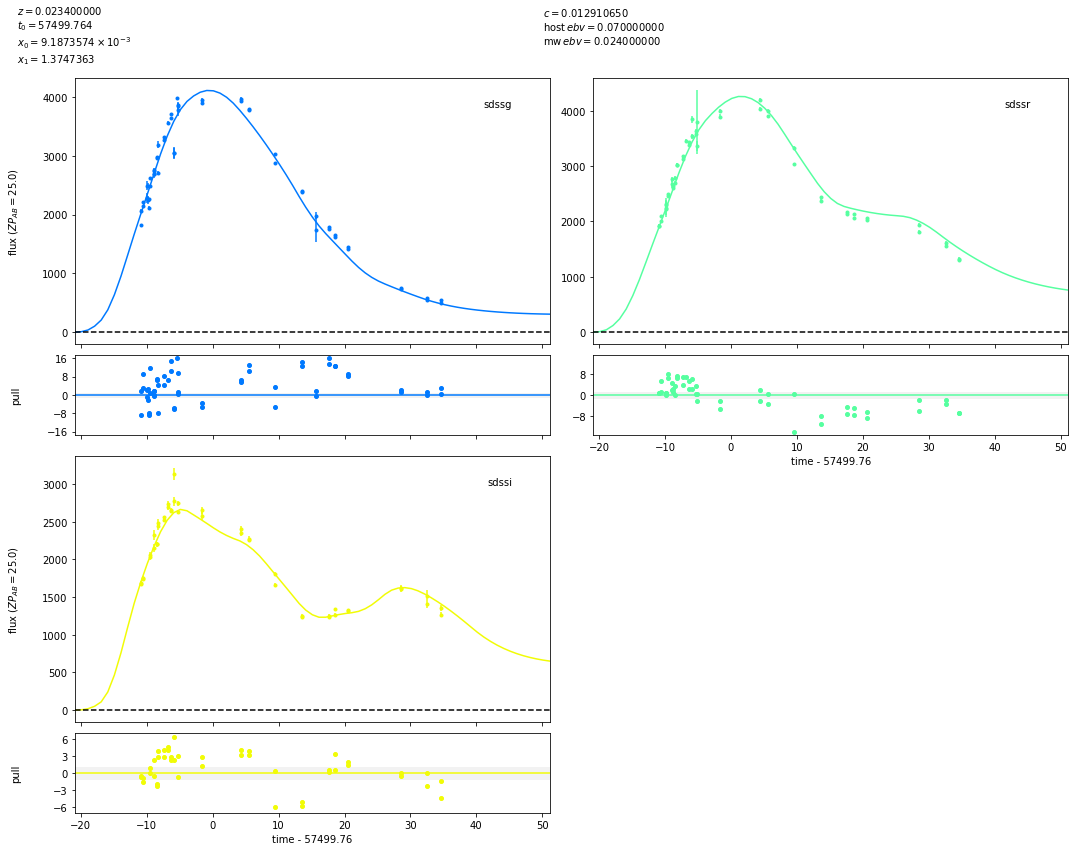

In [87]:
# sncosmo model
dust = sncosmo.F99Dust()
host_dust = sncosmo.F99Dust()
model = sncosmo.Model(source="salt2",
                      effects=[host_dust, dust],
                      effect_names=["host", "mw"],
                      effect_frames=["rest", "obs"])
model.set(z=params["z"])

model.set(t0=57598.)
model.set(hostebv=0.07)
model.set(mwebv=d.meta["mwebv"])

fit_parameter_list = ["t0", "x0", "x1", "c"]

res, fitted_model = sncosmo.fit_lc(d, model, fit_parameter_list,
                                   bounds={"t0": (57490, 57510), 
                                           "x1": (-5, 5)},
                                   guess_t0=False,
                                   modelcov = True)

fig = sncosmo.plot_lc(d, model=fitted_model, error=res.errors, xfigsize = 15)

m_Bast = fitted_model.source_peakmag(sncosmo.get_bandpass("bessellb"), 'ab')

print("B-band peak mag: {:5.2f}").format(m_Bast)

X_1 = res['parameters'][3]
X_1_err = res['errors']['x0']
C = res['parameters'][4]
C_err = res['errors']['c']
t_0 = res['parameters'][1]
t_0_err = res['errors']['t0']

print("""The fit produces the following values:
        x_1 = {:.6f} +/- {:.6f}
        c   = {:.6f} +/- {:.6f}
        t_0  = {:.6f} +/- {:.6f}

    """.format(X_1, X_1_err, C, C_err, t_0, t_0_err))

In [89]:
# cosmology nuisance parameters
alpha = 0.141
alpha_err = 0.006
beta = 3.101
beta_err = 0.075
M_B1 = -19.05
M_B1_err = 0.02

mu = m_Bast - (M_B1 - alpha*X_1 + beta*C)
print("The distance modulus is {:.4f}".format(mu))

mu_err = np.sqrt(M_B1_err**2 + X_1**2 * alpha_err**2 + alpha**2 * X_1_err**2 + 
                 beta**2 * C_err**2 + C**2 * beta_err**2)
print("The uncertainty on mu is {:.4f}".format(mu_err))

The distance modulus is 34.7967
The uncertainty on mu is 0.0805


# Power-law fit to the early light curve

In [60]:
# fit the early light curve
def EarlyLCModel(t, t0, alpha, C):
    return np.where(t > t0, 10**(C) * (t - t0)**alpha, 0)

g_lc = np.array([(row["time"], row["flux"], row["flux_err"])
                 for row in h5file.root.photometry
                 if row["filter_name"] == "g"],
                dtype=[("time", "f"), ("flux", "f"), ("flux_err", "f")])
g_lc.sort(order="time")
idx = np.logical_and(g_lc["time"] > 57478, g_lc["time"] < 57485)
early_lc = g_lc[idx]

# set searching grids
t0_range = np.linspace(57480, 57482, 201)
alpha_range = np.linspace(0.5, 2.5, 101)
C_range = np.linspace(-6, -3, 301)
X, Y, Z = np.meshgrid(t0_range, alpha_range, C_range)
chi2 = np.ndarray(X.shape)
l, m, n = chi2.shape
for i in range(l):
    for j in range(m):
        for k in range(n):
            chi2[i][j][k] = np.sum(
                ((early_lc["flux"] - EarlyLCModel(early_lc["time"], X[i][j][k], Y[i][j][k], Z[i][j][k])) /\
                 early_lc["flux_err"])**2)
chi2 -= np.min(chi2)
idx = np.where(chi2 == 0.0)
best_fit = {"t0": X[idx], "alpha": Y[idx], "C": Z[idx]}

/Users/adamamiller/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/adamamiller/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
prob = np.sum(np.exp(-chi2 / 2), axis=2)
prob /= np.sum(prob)
X_2D, Y_2D = np.meshgrid(t0_range, alpha_range)

flat_prob = prob.flatten()
flat_prob.sort()
total = 0
one_sigma = -1
three_sigma = -1
for num in flat_prob[::-1]:
    total += num
    if one_sigma < 0 and total > 0.68:
        one_sigma = num
    if three_sigma < 0 and total > 0.997:
        three_sigma = num

/Users/adamamiller/miniconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


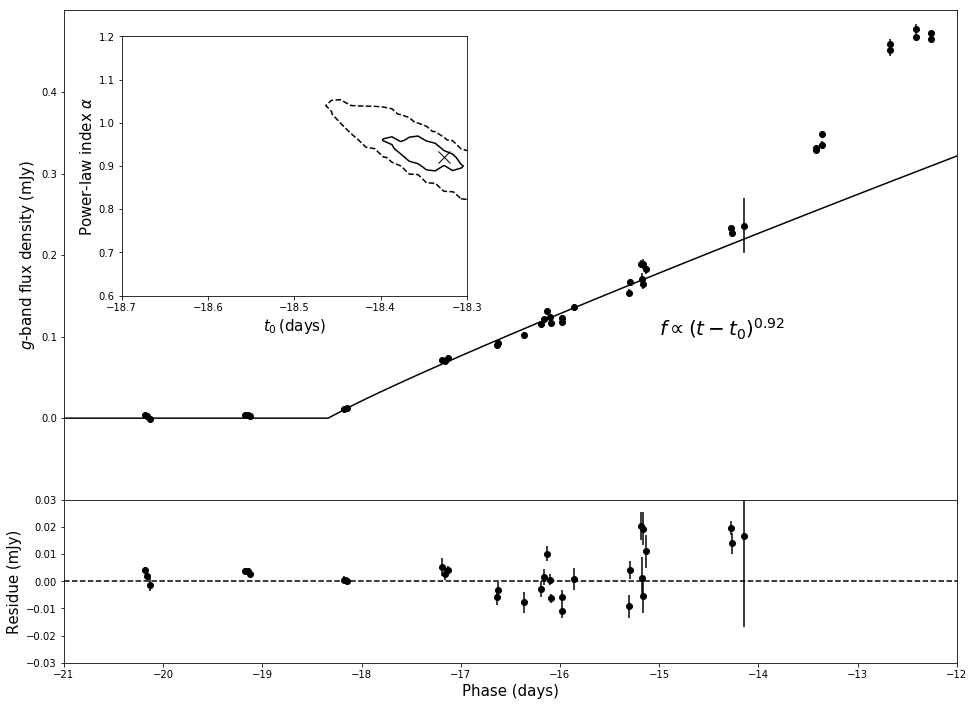

In [62]:
# make a nice plot for early data

fig = plt.figure(figsize=(16, 12))
fig.subplots_adjust(hspace=0.001)
ax = plt.subplot2grid([4, 1], [0, 0], rowspan=3)
res = plt.subplot2grid([4, 1], [3, 0])
t_max = 57499.537
ax.errorbar(g_lc["time"] - t_max, g_lc["flux"] * 1e3, 
            yerr=g_lc["flux_err"] * 1e3, 
            linestyle='none',
            marker='o',
            markersize=6,
            color='k')
t = np.linspace(-3, 10, 101) + best_fit["t0"]
ax.plot(t - t_max, 
        EarlyLCModel(t, best_fit["t0"], best_fit["alpha"], best_fit["C"]) * 1e3, 
        'k-')
ax.text(-15, 0.10, "$f\\propto (t-t_0)^{%.2f}$" % best_fit["alpha"], fontsize=20)

ax.set_xticklabels([])
ax.set_yticks(np.arange(0, 0.5, 0.1))
ax.set_ylabel("$g$-band flux density (mJy)", fontsize=15)
ax.set_xlim(-21, -12)
ax.set_ylim(-0.1, 0.5)

res.errorbar(g_lc["time"] - t_max, 
             (g_lc["flux"] - EarlyLCModel(g_lc["time"], best_fit["t0"], best_fit["alpha"], best_fit["C"])) * 1e3,
             yerr=g_lc["flux_err"] * 1e3,
             linestyle="none",
             marker="o", 
             markersize=6,
             color='k')
res.set_xlim(ax.get_xlim())
res.set_ylim(-0.03, 0.03)
res.hlines(0, *(res.get_xlim()), linestyle='--')

res.set_xlabel("Phase (days)", fontsize=15)
res.set_ylabel("Residue (mJy)", fontsize=15)


inset = fig.add_axes([0.175, 0.55, 0.3, 0.3])
contour = inset.contour(X_2D - t_max, Y_2D, prob, [three_sigma, one_sigma],
                        colors="k", linestyles=["--", "-"])
inset.plot(best_fit["t0"] - t_max, best_fit["alpha"], 'x', color="k", linestyle='none', markersize=12)
inset.set_xlim(-18.7, -18.3)
inset.set_ylim(0.6, 1.2)
inset.set_xticks(np.arange(-18.70, -18.20, 0.1))
inset.set_xlabel("$t_0\\,\\rm{(days)}$", fontsize=15)
inset.set_ylabel("Power-law index $\\alpha$", fontsize=15)

plt.savefig("early_lc.pdf")